In [6]:
import warnings
warnings.filterwarnings("ignore")

У нас есть достаточно большой датасет реальных и фейковых новостей на английском языке (подробности --> https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data?select=True.csv). Задача: опробовать методы классического машинного обучения для автоматического различения текстов этих классов. 

Обычно задача детекции фейк-ньюс решается нейросетевыми моделями – моей гипотезой будет предположение, что с помощью методов классического МО в комбинации с различными эвристиками – в частности, с использованием эмбеддингов и с выделением специальных лингвистических признаков текстов – тоже можно достичь удовлетворительного результата (под этим буду подразумевать преодоление бейзлайна, который я построю позже).


# 1. Downloading data

In [1]:
import pandas as pd

In [2]:
df_true = pd.read_csv('True.csv').sample(frac=0.3, random_state=30)
# кажется, что будет достаточно взять 30-40% подвыборок:
# это достаточно много, чтобы получить хороший результат
# и достаточно немного, чтобы модели учились быстрее
df_true['target'] = 0
df_true

,title,text,subject,date,target
10303,Obama commends Northern Ireland leaders on pea...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"March 17, 2016",0
11264,South Korea president says acquiring nukes wou...,SEOUL (Reuters) - If South Korea develops nucl...,politicsNews,"January 13, 2016",0
18558,Catalan leader opens door to secession from Sp...,BARCELONA (Reuters) - Catalonia s regional lea...,worldnews,"October 1, 2017",0
17160,Japan ruling coalition seen winning around two...,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,"October 18, 2017",0
18759,British Columbia hires investigator to probe m...,VANCOUVER (Reuters) - British Columbia has hir...,worldnews,"September 29, 2017",0
...,...,...,...,...,...
1709,California bill to wean power sector off fossi...,"SACRAMENTO, Calif. (Reuters) - A long-shot pla...",politicsNews,"September 16, 2017",0
18145,Catalan leader Puigdemont to address Catalan p...,BARCELONA (Reuters) - Catalan leader Carles Pu...,worldnews,"October 6, 2017",0
17130,Romania finalizes draft of judiciary overhaul ...,BUCHAREST (Reuters) - Romania has put the fini...,worldnews,"October 18, 2017",0
15777,South African prosecutors say Pistorius senten...,"BLOEMFONTEIN, South Africa (Reuters) - South A...",worldnews,"November 3, 2017",0


In [3]:
df_fake = pd.read_csv('Fake.csv').sample(frac=0.3, random_state=30) # аналогично
df_fake['target'] = 1
df_fake

,title,text,subject,date,target
17898,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",left-news,"Sep 28, 2017",1
14943,REPUBLICAN DEBATE: Trump And Kasich Go At It O...,Governor Kasich: What Mr Trump needs to under...,politics,"Nov 11, 2015",1
5969,Clinton Trolls Trump With AWESOME New Website,After emerging victorious in the Democratic Pr...,News,"June 8, 2016",1
20091,SECRET SERVICE AGENT Says Hillary Has Parkinso...,Hillary had several chances over the years to ...,left-news,"Aug 20, 2016",1
16076,LIKE A BOSS! President Trump’s Arrival at the ...,President Trump arrived like a boss to check...,Government News,"May 25, 2017",1
...,...,...,...,...,...
21563,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,Baltimore City State s Attorney Marilyn Mosby ...,left-news,"Jul 15, 2015",1
11811,GREAT SPEECH! PRESIDENT TRUMP Doubles Down On ...,https://www.youtube.com/watch?v=mEfQYHciqaQDur...,politics,"Jan 25, 2017",1
16253,DEFIANT NATIONAL PARK SERVICE STAFF GOES ROGUE...,The employees went on twitter to speak about g...,Government News,"Jan 26, 2017",1
5277,Donald Trump Throws MASSIVE Hissy Fit Over Hi...,Hillary Clinton delivered an amazing speech on...,News,"July 29, 2016",1


In [4]:
news_df_raw = pd.concat([df_true, df_fake], ignore_index=True)
news_df_raw
# таргет: 0 – реальная новость, 1 – фейк

,title,text,subject,date,target
0,Obama commends Northern Ireland leaders on pea...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"March 17, 2016",0
1,South Korea president says acquiring nukes wou...,SEOUL (Reuters) - If South Korea develops nucl...,politicsNews,"January 13, 2016",0
2,Catalan leader opens door to secession from Sp...,BARCELONA (Reuters) - Catalonia s regional lea...,worldnews,"October 1, 2017",0
3,Japan ruling coalition seen winning around two...,TOKYO (Reuters) - Japanese Prime Minister Shin...,worldnews,"October 18, 2017",0
4,British Columbia hires investigator to probe m...,VANCOUVER (Reuters) - British Columbia has hir...,worldnews,"September 29, 2017",0
...,...,...,...,...,...
13464,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,Baltimore City State s Attorney Marilyn Mosby ...,left-news,"Jul 15, 2015",1
13465,GREAT SPEECH! PRESIDENT TRUMP Doubles Down On ...,https://www.youtube.com/watch?v=mEfQYHciqaQDur...,politics,"Jan 25, 2017",1
13466,DEFIANT NATIONAL PARK SERVICE STAFF GOES ROGUE...,The employees went on twitter to speak about g...,Government News,"Jan 26, 2017",1
13467,Donald Trump Throws MASSIVE Hissy Fit Over Hi...,Hillary Clinton delivered an amazing speech on...,News,"July 29, 2016",1


In [5]:
# во второй лабе было хорошо показано, что предсказания модели, обученной на одних только заголовках,
# скорее всего априори будут хуже предсказаний на текстах (что логично и предсказуемо),
# поэтому давайте сразу склеим их вместе:
news_df = pd.DataFrame()
news_df['title+text'] = news_df_raw['title'] + '. ' + news_df_raw['text']
news_df[['subject', 'date', 'target']] = news_df_raw[['subject', 'date', 'target']]
news_df

,title+text,subject,date,target
0,Obama commends Northern Ireland leaders on pea...,politicsNews,"March 17, 2016",0
1,South Korea president says acquiring nukes wou...,politicsNews,"January 13, 2016",0
2,Catalan leader opens door to secession from Sp...,worldnews,"October 1, 2017",0
3,Japan ruling coalition seen winning around two...,worldnews,"October 18, 2017",0
4,British Columbia hires investigator to probe m...,worldnews,"September 29, 2017",0
...,...,...,...,...
13464,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,left-news,"Jul 15, 2015",1
13465,GREAT SPEECH! PRESIDENT TRUMP Doubles Down On ...,politics,"Jan 25, 2017",1
13466,DEFIANT NATIONAL PARK SERVICE STAFF GOES ROGUE...,Government News,"Jan 26, 2017",1
13467,Donald Trump Throws MASSIVE Hissy Fit Over Hi...,News,"July 29, 2016",1


In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13469 entries, 0 to 13468
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title+text  13469 non-null  object
 1   subject     13469 non-null  object
 2   date        13469 non-null  object
 3   target      13469 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 421.0+ KB


Я придерживаюсь следующей логики: при использовании эмбеддингов модель будет "выучивать" семантику и смысл слов/текстов, а при использовании языковых фичей – формальные признаки текстов (графические, грамматические и т.п.). Таким образом для построения эмбеддингов нам нужно форматировать текст, а вот для вычисления признаков мы работаем с сырым текстом.

# 2. Extracting linguistic features

In [33]:
import re
import nltk
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

Я буду использовать как универсальные и простые признаки (будь то частность слов, символов, знаков препинания и т.п.), которые часто используются в подобных работах и, на мой взгляд, релевантны для нашего материала, так и более сложные, выделенные исследователями в работах по автоматическому определению фейк ньюс.

In [34]:
news_df['title+text'][0]

'Obama commends Northern Ireland leaders on peace progress: White House. WASHINGTON (Reuters) - U.S. President Barack Obama met with two Northern Ireland leaders and commended them on the progress being made towards peace, the White House said on Wednesday. Obama dropped by a meeting on Tuesday between Vice President Joe Biden, Northern Ireland First Minister Arlene Foster and deputy First Minister Martin McGuinness, the White House said in a statement. Obama and Biden\xa0urged the ministers to move forward with implementation of the Stormont House Agreement of December 2014 and the Fresh Start Agreement of November 2015, the statement said. '

In [35]:
news_df_features = pd.DataFrame(index=news_df.index)
news_df_features

""
0
1
2
3
4
...
13464
13465
13466
13467


## 2.1 Simple features

In [36]:
# функция для создания и доавления нового простого текстового признака

def add_simple_feature(func, feature_name):
    new_feature = news_df['title+text'].apply(func) # применяем функцию, считающую какое-либо значение по тексту,
                                                    # к каждому тексту
    new_feature.name = feature_name
    return news_df_features.join(new_feature)

In [37]:
# 1. количество слов
def get_words_count(text):
    return len(re.findall(r'[\w\']+', text)) # прим. части слов с дефисами придётся считать отдельными словами,
                                            # т.к. в текстах дефис используется как тире

news_df_features = add_simple_feature(get_words_count, 'words_count')
news_df_features

,words_count
0,100
1,82
2,766
3,274
4,224
...,...
13464,903
13465,109
13466,105
13467,990


In [38]:
# 2. средняя длина слова (в символах)
def get_mean_word_len(text):
    words = re.findall(r'[\w\']+', text)
    return sum([len(w) for w in words]) / len(words)

news_df_features = add_simple_feature(get_mean_word_len, 'mean_word_lenght')
news_df_features

,words_count,mean_word_lenght
0,100,5.320000
1,82,4.865854
2,766,4.986945
3,274,4.916058
4,224,5.303571
...,...,...
13464,903,4.708749
13465,109,4.541284
13466,105,5.409524
13467,990,4.564646


In [39]:
# 3. количество предложений 
def get_sents_count(text):
    return len(sent_tokenizer.tokenize(text)) # используемый nltk-шный токенайзер предложений,
                                                # обученный для английского языка и поэтому могущий работать
                                                # со сложными случаями (сокращениями с точкой и т.п.)

news_df_features = add_simple_feature(get_sents_count, 'sentences_count')
news_df_features

,words_count,mean_word_lenght,sentences_count
0,100,5.320000,4
1,82,4.865854,3
2,766,4.986945,30
3,274,4.916058,10
4,224,5.303571,8
...,...,...,...
13464,903,4.708749,27
13465,109,4.541284,6
13466,105,5.409524,4
13467,990,4.564646,49


In [40]:
# 4. средняя длина предложения (в словах)
def get_mean_sent_len(text):
    sentences = sent_tokenizer.tokenize(text)
    return sum([
        len(re.findall(r'[\w\']+', s)) for s in sentences
    ]) / len(sentences)

news_df_features = add_simple_feature(get_mean_sent_len, 'mean_sentence_lenght')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght
0,100,5.320000,4,25.000000
1,82,4.865854,3,27.333333
2,766,4.986945,30,25.533333
3,274,4.916058,10,27.400000
4,224,5.303571,8,28.000000
...,...,...,...,...
13464,903,4.708749,27,33.444444
13465,109,4.541284,6,18.166667
13466,105,5.409524,4,26.250000
13467,990,4.564646,49,20.204082


In [41]:
# 5. количество знаков препинания
def get_punct_count(text):
    return len(re.findall(r'[^\w\'\s]+', text))

news_df_features = add_simple_feature(get_punct_count, 'punctuation_marks_count')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count
0,100,5.320000,4,25.000000,14
1,82,4.865854,3,27.333333,15
2,766,4.986945,30,25.533333,88
3,274,4.916058,10,27.400000,45
4,224,5.303571,8,28.000000,32
...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112
13465,109,4.541284,6,18.166667,18
13466,105,5.409524,4,26.250000,16
13467,990,4.564646,49,20.204082,164


In [42]:
# 6. количество чисел
def get_numbers_count(text):
    return len(re.findall(r'[0-9]+', text))

news_df_features = add_simple_feature(get_numbers_count, 'numbers_count')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count
0,100,5.320000,4,25.000000,14,2
1,82,4.865854,3,27.333333,15,1
2,766,4.986945,30,25.533333,88,15
3,274,4.916058,10,27.400000,45,5
4,224,5.303571,8,28.000000,32,6
...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32
13465,109,4.541284,6,18.166667,18,0
13466,105,5.409524,4,26.250000,16,0
13467,990,4.564646,49,20.204082,164,32


In [43]:
# 7. отношение букв верхнего регистра к нижним
def get_registers_ratio(text):
    return len(re.findall(r'[A-Z]', text)) / (len(re.findall(r'[a-z]', text)) + 0.00000001) # чтобы избежать деления на ноль

news_df_features = add_simple_feature(get_registers_ratio, 'registers_ratio')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio
0,100,5.320000,4,25.000000,14,2,0.117271
1,82,4.865854,3,27.333333,15,1,0.081967
2,766,4.986945,30,25.533333,88,15,0.028253
3,274,4.916058,10,27.400000,45,5,0.052050
4,224,5.303571,8,28.000000,32,6,0.045374
...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990
13465,109,4.541284,6,18.166667,18,0,0.130137
13466,105,5.409524,4,26.250000,16,0,0.305747
13467,990,4.564646,49,20.204082,164,32,0.073248


## 2.2. POS features

In [64]:
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [77]:
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words_en = stopwords.words('english')
stop_words_en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Посчитаем встречаемость разных знаменательных частей речи, стоп-слов – я предполагаю, что их доля может отличаться в двух типах новостей (это также подтверждается исследованиями).

In [65]:
# сначала достанем части речи всех слов текста
def get_pos_tags(text):
    tokens_pos = pos_tag(word_tokenize(text), tagset='universal')
    return [token[1] for token in tokens_pos]

news_df_pos = news_df['title+text'].apply(get_pos_tags)
news_df_pos

0        [NOUN, VERB, NOUN, NOUN, NOUN, ADP, NOUN, NOUN...
1        [NOUN, NOUN, NOUN, VERB, VERB, NOUN, VERB, VER...
2        [ADJ, NOUN, VERB, NOUN, PRT, NOUN, ADP, NOUN, ...
3        [NOUN, VERB, NOUN, VERB, VERB, ADP, NOUN, NOUN...
4        [ADJ, NOUN, NOUN, NOUN, PRT, VERB, NOUN, NOUN,...
                               ...                        
13464    [ADJ, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN...
13465    [ADJ, NOUN, ., NOUN, NOUN, NOUN, NOUN, ADP, NO...
13466    [NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, ., ...
13467    [NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, NOU...
13468    [NOUN, NOUN, NOUN, ., NUM, ADP, NOUN, NOUN, AD...
Name: title+text, Length: 13469, dtype: object

In [66]:
# адаптируем функцию для выделения фичей под новую задачу

def add_pos_feature(func, feature_name):
    new_feature = news_df_pos.apply(func) 
    
    new_feature.name = feature_name
    return news_df_features.join(new_feature)

In [68]:
# 1. количество существительных
def get_nouns_count(pos_list):
    return len([pos for pos in pos_list
               if pos == 'NOUN' or pos == 'PNOUN'])

news_df_features = add_pos_feature(get_nouns_count, 'NOUN_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57
1,82,4.865854,3,27.333333,15,1,0.081967,42
2,766,4.986945,30,25.533333,88,15,0.028253,257
3,274,4.916058,10,27.400000,45,5,0.052050,97
4,224,5.303571,8,28.000000,32,6,0.045374,86
...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311
13465,109,4.541284,6,18.166667,18,0,0.130137,40
13466,105,5.409524,4,26.250000,16,0,0.305747,49
13467,990,4.564646,49,20.204082,164,32,0.073248,392


In [69]:
# 2. количество прилагательных
def get_adjectives_count(pos_list):
    return len([pos for pos in pos_list
               if pos == 'ADJ'])

news_df_features = add_pos_feature(get_adjectives_count, 'ADJ_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0
1,82,4.865854,3,27.333333,15,1,0.081967,42,8
2,766,4.986945,30,25.533333,88,15,0.028253,257,59
3,274,4.916058,10,27.400000,45,5,0.052050,97,27
4,224,5.303571,8,28.000000,32,6,0.045374,86,26
...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56


In [70]:
# 3. количество глаголов
def get_verbs_count(pos_list):
    return len([pos for pos in pos_list
               if pos == 'VERB'])

news_df_features = add_pos_feature(get_verbs_count, 'VERB_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34
...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156


In [71]:
# 4. количество местоимений
def get_pronouns_count(pos_list):
    return len([pos for pos in pos_list
               if pos == 'PRON'])

news_df_features = add_pos_feature(get_pronouns_count, 'PRON_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6
...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80


In [72]:
# 5. количество наречий
def get_adverbs_count(pos_list):
    return len([pos for pos in pos_list
               if pos == 'ADV'])

news_df_features = add_pos_feature(get_adverbs_count, 'ADV_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55


In [73]:
# 6. количество числительных
def get_numerals_count(pos_list):
    return len([pos for pos in pos_list
               if pos == 'NUM'])

news_df_features = add_pos_feature(get_numerals_count, 'NUM_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36


In [74]:
# 7. количество слов некоторых служебных ЧР 
#   (союзы, предлоги, частицы, артикли, глаголы-связки)
def get_functional_words_count(pos_list):
    return len([pos for pos in pos_list
               if pos in ['AUX', 'CCONJ', 'DET', 'PART', 'SCONJ']])

news_df_features = add_pos_feature(get_functional_words_count, 'functional_words_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts,functional_words_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3,9
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1,4
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13,90
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2,25
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30,71
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1,9
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1,12
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36,76


In [79]:
# 8. количество стоп-слов
def get_stop_words_count(text):
    words = re.findall(r'[\w\']+', text)
    return len([word for word in words 
                if word in stop_words_en])

news_df_features = add_simple_feature(get_stop_words_count, 'stop_words_count')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3,9,0,28
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1,4,0,22
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13,90,0,298
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2,25,0,86
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6,20,0,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30,71,0,343
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1,9,0,39
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1,12,0,25
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36,76,0,379


## 2.3. NER features

Есть смысл посчитать количество упоминаемых именованных сущностей (людей, названий, локаций и т.п.) – вероятно, что в фейк ньюс их будет больше, например, из-за того, что тексты могут быть направлены на дискредитацию кого-либо и т.п. Я решил выбрать несколько наиболее частотных и важных для дискурса новостей.

In [88]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 3.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [89]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [97]:
# сначала достанем все именованные сущности из каждого текста
def get_ner_tags(text):
    docs = nlp.pipe([text],
               disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
    return [ner.label_ for doc in docs 
            for ner in doc.ents]

news_df_ner = news_df['title+text'].apply(get_ner_tags)
news_df_ner

0        [GPE, GPE, ORG, GPE, ORG, GPE, PERSON, CARDINA...
1        [GPE, ORG, ORG, GPE, GPE, ORDINAL, NORP, PERSO...
2        [NORP, GPE, ORG, GPE, GPE, DATE, PERCENT, NORP...
3        [GPE, CARDINAL, ORG, ORG, NORP, PERSON, CARDIN...
4        [GPE, PERSON, ORG, ORG, NORP, DATE, GPE, NORP,...
                               ...                        
13464    [ORG, CARDINAL, PERSON, GPE, PERSON, ORG, QUAN...
13465                          [GPE, GPE, TIME, ORG, DATE]
13466     [PRODUCT, ORG, ORG, ORG, CARDINAL, PRODUCT, ORG]
13467    [PERSON, PERSON, ORG, PERSON, DATE, TIME, ORG,...
13468    [ORG, MONEY, ORG, ORG, DATE, CARDINAL, CARDINA...
Name: title+text, Length: 13469, dtype: object

In [103]:
# адаптируем функцию для выделения фичей под новую задачу

def add_ner_feature(func, feature_name):
    new_feature = news_df_ner.apply(func) 
    
    new_feature.name = feature_name
    return news_df_features.join(new_feature)

In [104]:
# 1. количество всех именованных сущностей
def get_ners_count(ner_list):
    return len(ner_list)

news_df_features = add_ner_feature(get_ners_count, 'NER_tags_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count,NER_tags_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3,9,0,28,25
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1,4,0,22,16
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13,90,0,298,71
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2,25,0,86,43
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6,20,0,71,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30,71,0,343,95
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1,9,0,39,5
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1,12,0,25,7
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36,76,0,379,137


In [107]:
# 2. количество личностей (PERSON)
def get_persons_count(ner_list):
    return len([ner for ner in ner_list
               if ner == 'PERSON'])

news_df_features = add_ner_feature(get_persons_count, 'PERSON_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count,NER_tags_counts,PERSON_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3,9,0,28,25,7
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1,4,0,22,16,2
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13,90,0,298,71,6
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2,25,0,86,43,5
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6,20,0,71,26,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30,71,0,343,95,22
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1,9,0,39,5,0
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1,12,0,25,7,0
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36,76,0,379,137,42


In [108]:
# 3. количество социальных групп (NORP)
def get_groups_count(ner_list):
    return len([ner for ner in ner_list
               if ner == 'NORP'])

news_df_features = add_ner_feature(get_groups_count, 'NORP_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3,9,0,28,25,7,0
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1,4,0,22,16,2,1
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13,90,0,298,71,6,9
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2,25,0,86,43,5,3
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6,20,0,71,26,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30,71,0,343,95,22,0
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1,9,0,39,5,0,0
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1,12,0,25,7,0,0
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36,76,0,379,137,42,4


In [109]:
# 4. количество компаний (ORG)
def get_orgs_count(ner_list):
    return len([ner for ner in ner_list
               if ner == 'ORG'])

news_df_features = add_ner_feature(get_orgs_count, 'ORG_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,1,1,3,9,0,28,25,7,0,5
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,2,0,1,4,0,22,16,2,1,3
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,20,18,13,90,0,298,71,6,9,9
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,9,6,2,25,0,86,43,5,3,15
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,6,3,6,20,0,71,26,3,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,53,35,30,71,0,343,95,22,0,13
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,13,4,1,9,0,39,5,0,0,1
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,3,0,1,12,0,25,7,0,0,4
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,80,55,36,76,0,379,137,42,4,34


In [110]:
# 5. количество административных территорий (GPE)
def get_gpes_count(ner_list):
    return len([ner for ner in ner_list
               if ner == 'GPE'])

news_df_features = add_ner_feature(get_gpes_count, 'GPE_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,ADV_counts,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,1,3,9,0,28,25,7,0,5,6
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,0,1,4,0,22,16,2,1,3,6
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,18,13,90,0,298,71,6,9,9,22
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,6,2,25,0,86,43,5,3,15,5
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,3,6,20,0,71,26,3,5,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,35,30,71,0,343,95,22,0,13,17
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,4,1,9,0,39,5,0,0,1,2
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,0,1,12,0,25,7,0,0,4,0
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,55,36,76,0,379,137,42,4,34,17


In [115]:
# 6. количество дат (DATE)
def get_dates_count(ner_list):
    return len([ner for ner in ner_list
               if ner == 'DATE'])

news_df_features = add_ner_feature(get_dates_count, 'DATE_counts')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,NUM_counts,functional_words_counts,INTJ_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,3,9,0,28,25,7,0,5,6,4
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,1,4,0,22,16,2,1,3,6,3
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,13,90,0,298,71,6,9,9,22,9
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,2,25,0,86,43,5,3,15,5,6
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,6,20,0,71,26,3,5,3,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,30,71,0,343,95,22,0,13,17,27
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,1,9,0,39,5,0,0,1,2,1
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,1,12,0,25,7,0,0,4,0,0
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,36,76,0,379,137,42,4,34,17,23


In [149]:
news_df_features.to_excel('news_df_features.xlsx')

## 2.4. Style/readability features

In [48]:
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, SyllableTokenizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


В работах по данной теме часто исследуется применение метрик стилометрии для решения задачи. Я использую несколько из них в качестве фичей.

In [42]:
news_df_features = pd.read_excel('news_df_features.xlsx').drop(['Unnamed: 0', 'INTJ_counts'], axis=1)
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,ADV_counts,NUM_counts,functional_words_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,1,3,9,28,25,7,0,5,6,4
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,0,1,4,22,16,2,1,3,6,3
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,18,13,90,298,71,6,9,9,22,9
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,6,2,25,86,43,5,3,15,5,6
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,3,6,20,71,26,3,5,3,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,35,30,71,343,95,22,0,13,17,27
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,4,1,9,39,5,0,0,1,2,1
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,0,1,12,25,7,0,0,4,0,0
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,55,36,76,379,137,42,4,34,17,23


In [46]:
# здесь нам подойдёт функция, использовавшаяся для простых фичей

def add_simple_feature(func, feature_name):
    new_feature = news_df['title+text'].apply(func) 
    
    new_feature.name = feature_name
    return news_df_features.join(new_feature)

In [47]:
# 1. Type-token ratio (TTR)
# это отношение кол-ва уникальных токенов ко всем
# будет считать по лемматизированному корпусу
def get_type_token_ratio(text):
    tokenizer = RegexpTokenizer(r'[\w\']+') 
    lemmatizer = WordNetLemmatizer()
    
    tokenized_text = tokenizer.tokenize(text)
        
    lemmatized_text = [lemmatizer.lemmatize(word.lower())
                          for word in tokenized_text]
    
    return len(set(lemmatized_text)) / len(lemmatized_text)

news_df_features = add_simple_feature(get_type_token_ratio, 'TTR score')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,NUM_counts,functional_words_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,3,9,28,25,7,0,5,6,4,0.600000
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,1,4,22,16,2,1,3,6,3,0.658537
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,13,90,298,71,6,9,9,22,9,0.472585
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,2,25,86,43,5,3,15,5,6,0.525547
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,6,20,71,26,3,5,3,6,5,0.620536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,30,71,343,95,22,0,13,17,27,0.383167
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,1,9,39,5,0,0,1,2,1,0.788991
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,1,12,25,7,0,0,4,0,0,0.704762
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,36,76,379,137,42,4,34,17,23,0.412121


In [56]:
# 2. количество слогов
def get_syllables_count(text):
    tokenizer = SyllableTokenizer()    
    return len(tokenizer.tokenize(text))

news_df_features = add_simple_feature(get_syllables_count, 'syllabels_count')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,functional_words_counts,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score,syllabels_count
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,9,28,25,7,0,5,6,4,0.600000,249
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,4,22,16,2,1,3,6,3,0.658537,198
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,90,298,71,6,9,9,22,9,0.472585,1899
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,25,86,43,5,3,15,5,6,0.525547,687
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,20,71,26,3,5,3,6,5,0.620536,585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,71,343,95,22,0,13,17,27,0.383167,2150
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,9,39,5,0,0,1,2,1,0.788991,238
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,12,25,7,0,0,4,0,0,0.704762,238
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,76,379,137,42,4,34,17,23,0.412121,2367


In [67]:
# 3. Flesch–Kincaid readability tests
# одна из количественных оценок читаемости текста: ru.wikipedia.org/wiki/Индекс_удобочитаемости
def get_fleisch_score(text):
    index = news_df[news_df['title+text'] == text].index[0]
    
    fraction1 = news_df_features['words_count'][index] / news_df_features['sentences_count'][index]
    fraction2 = news_df_features['syllabels_count'][index] / news_df_features['words_count'][index]
    
    return 206.835 - 1.015*fraction1 - 84.6*fraction2

news_df_features = add_simple_feature(get_fleisch_score, 'Flesch–Kincaid score')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,stop_words_count,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score,syllabels_count,Flesch–Kincaid score
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,28,25,7,0,5,6,4,0.600000,249,-29.194000
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,22,16,2,1,3,6,3,0.658537,198,-25.186382
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,298,71,6,9,9,22,9,0.472585,1899,-28.814232
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,86,43,5,3,15,5,6,0.525547,687,-33.093518
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,71,26,3,5,3,6,5,0.620536,585,-42.526964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,343,95,22,0,13,17,27,0.383167,2150,-28.539683
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,39,5,0,0,1,2,1,0.788991,238,3.672898
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,25,7,0,0,4,0,0,0.704762,238,-11.568750
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,379,137,42,4,34,17,23,0.412121,2367,-15.943052


In [68]:
# 4. Автоматический индекс удобочитаемости
# тоже одна из количественных оценок читаемости текста: ru.wikipedia.org/wiki/Автоматический_индекс_удобочитаемости
def get_readability_score(text):
    index = news_df[news_df['title+text'] == text].index[0]
    
    letter_num_count = len([symbol for symbol in text 
                            if symbol.isalpha() or symbol.isdigit()])
    fraction1 = letter_num_count / news_df_features['words_count'][index]
    fraction2 = news_df_features['words_count'][index] / news_df_features['sentences_count'][index]
    
    return 4.71*fraction1 + 0.5*fraction2 - 21.43

news_df_features = add_simple_feature(get_readability_score, 'Automated readability score')
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score,syllabels_count,Flesch–Kincaid score,Automated readability score
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,25,7,0,5,6,4,0.600000,249,-29.194000,16.127200
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,16,2,1,3,6,3,0.658537,198,-25.186382,15.039959
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,71,6,9,9,22,9,0.472585,1899,-28.814232,14.825178
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,43,5,3,15,5,6,0.525547,687,-33.093518,15.424635
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,26,3,5,3,6,5,0.620536,585,-42.526964,17.549821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,95,22,0,13,17,27,0.383167,2150,-28.539683,17.470428
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,5,0,0,1,2,1,0.788991,238,3.672898,9.042783
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,7,0,0,4,0,0,0.704762,238,-11.568750,17.173857
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,137,42,4,34,17,23,0.412121,2367,-15.943052,10.166768


## 2.5. Datasets finalization

### loading data, if necessairy

In [7]:
news_df_features = pd.read_excel('news_df_features.xlsx').drop('Unnamed: 0', axis=1)
news_df_features

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score,syllabels_count,Flesch–Kincaid score,Automated readability score
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,25,7,0,5,6,4,0.600000,249,-29.194000,16.127200
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,16,2,1,3,6,3,0.658537,198,-25.186382,15.039959
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,71,6,9,9,22,9,0.472585,1899,-28.814232,14.825178
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,43,5,3,15,5,6,0.525547,687,-33.093518,15.424635
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,26,3,5,3,6,5,0.620536,585,-42.526964,17.549821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,95,22,0,13,17,27,0.383167,2150,-28.539683,17.470428
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,5,0,0,1,2,1,0.788991,238,3.672898,9.042783
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,7,0,0,4,0,0,0.704762,238,-11.568750,17.173857
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,137,42,4,34,17,23,0.412121,2367,-15.943052,10.166768


### normalizing and splitting data

Теперь, когда мы собрали все нужные признаки, нужно привести их к одному распределению – мы видим, что разные значения, разные величины отличаются достаточно сильно. Поэтому будем нормализовывать

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
# сначала полученную выборку делим на трейн и тест
X_train_feat_raw, X_test_feat_raw, y_train_feat, y_test_feat = train_test_split(
                                                news_df_features,
                                                news_df['target'],
                                                test_size=0.3,
                                                stratify=news_df['target'],
                                                random_state=42
                                                )

In [10]:
# берём индексы объектов обучающей и тестовой выборок
train_indices = X_train_feat_raw.index
test_indices = X_test_feat_raw.index

In [12]:
# нормализуем
scaler = StandardScaler()
scaler.fit(X_train_feat_raw)

X_train_feat = scaler.transform(X_train_feat_raw)
X_test_feat = scaler.transform(X_test_feat_raw)

# 3. Exploratory data analysis of linguistic features

Теперь с выделенными признаками мы можем всесторонне рассмотреть наши данные, выявить какие-то закономерности, предположить, какие признаки появляют на предсказание в большей степени

In [13]:
import matplotlib.pyplot as plt

In [14]:
news_df_train = news_df.loc[train_indices]
news_df_train

,title+text,subject,date,target
220,U.S. Republicans push back on Democratic gun-c...,politicsNews,"July 5, 2016",0
11474,Trump Comes Unglued Once Again In Ongoing Feu...,News,"August 26, 2016",1
6180,Trump Justice Department civil rights nominee ...,politicsNews,"September 6, 2017",0
5022,Rights group files legal request on Trump busi...,politicsNews,"January 20, 2017",0
7516,Rape Deemed Legal In Oklahoma Because You Can...,News,"April 28, 2016",1
...,...,...,...,...
465,No sign of end to fight on U.S. ambassador to ...,politicsNews,"March 3, 2016",0
670,Cuba decries U.S. expulsion of 15 diplomats. H...,politicsNews,"October 3, 2017",0
11853,"Donald Trump Just Tweeted His Most INSANE, Co...",News,"July 22, 2017",1
8644,Chris Matthews Stuns Colleagues By Telling Th...,News,"February 10, 2016",1


[]

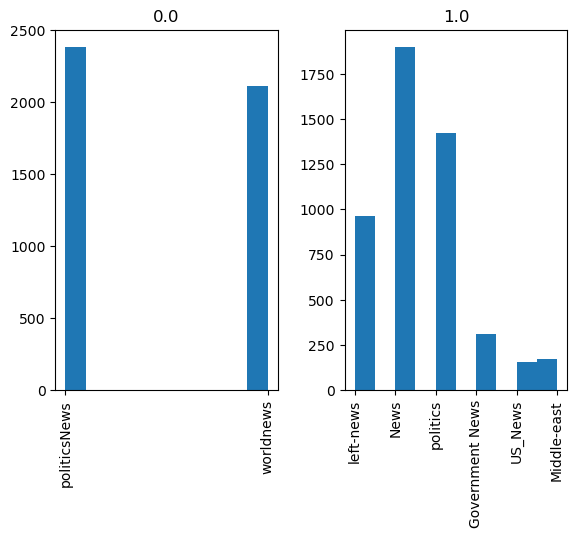

In [16]:
# во-первых, тексты различаются по представленным в них тематиках. давайте сравним
news_df['subject'].hist(by=news_df_train['target'])
plt.plot()

В датасете достаточно странно маркированы темы статей, в частности, они не пересекаются в двух классах, однако всё равно можно заметить тендценцию в целом к разнообразию тем в корпусе фейковых новостей и, хотя по соотношению "политика vs. новости" оба подкорпуса оказываются похожи.

In [17]:
# теперь я хочу посмотреть на разницу между средними значениями каждого признака среди выделенных нами
X_train_feat_raw['target'] = news_df['target']
X_train_feat_raw.groupby('target').mean()

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score,syllabels_count,Flesch–Kincaid score,Automated readability score
target,,,,,,,,,,,,,,,,,,,,,
0,404.706916,4.942256,15.859907,25.829254,58.654436,6.263509,5.568004e-02,150.170781,32.525906,72.701356,...,52.062041,8.402935,5.488993,12.219257,11.938626,7.434067,0.552166,985.171670,-26.754091,14.753397
1,462.038937,4.711910,16.372744,29.088680,60.991077,7.644900,2.474143e+07,155.530521,33.234841,82.453458,...,44.282093,11.614683,3.700264,11.222064,5.763334,5.023930,0.557557,1083.356723,-19.273342,15.302728


In [18]:
X_train_feat_raw.groupby('target')[['PRON_counts', 'ADV_counts', 'NUM_counts', 'functional_words_counts', 'stop_words_count']].mean()

,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,stop_words_count
target,,,,,
0,15.98221,12.758506,7.203469,40.390483,148.998443
1,28.29345,21.516731,7.556885,44.654026,180.688096


In [19]:
# и между отклонениями
X_train_feat_raw.groupby('target').std()

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,NER_tags_counts,PERSON_counts,NORP_counts,ORG_counts,GPE_counts,DATE_counts,TTR score,syllabels_count,Flesch–Kincaid score,Automated readability score
target,,,,,,,,,,,,,,,,,,,,,
0,284.137193,0.251766,11.897001,5.084545,42.867879,7.910064,2.148121e-02,101.195574,24.404679,54.197867,...,34.612810,7.888061,5.682035,9.855064,11.511763,5.666532,0.087834,682.661806,10.838758,2.841231
1,438.502340,0.329318,14.001774,12.127845,58.900793,12.074677,4.485274e+08,149.262285,38.745663,73.825662,...,45.695221,12.589363,5.813166,13.560262,9.620052,6.314335,0.126450,1063.623555,19.521418,6.517350


In [20]:
X_train_feat_raw.groupby('target')[['PRON_counts', 'ADV_counts', 'NUM_counts', 'functional_words_counts', 'stop_words_count']].std()

,PRON_counts,ADV_counts,NUM_counts,functional_words_counts,stop_words_count
target,,,,,
0,17.363772,11.910641,7.934042,30.054171,111.376113
1,26.051643,21.099510,10.552898,47.765723,171.006790


Здесь хотя мы и не проверяем статистическую значимость различий, "на глаз" можно сказать, что есть отличия по соотношению регистров (и правда фейк ньюс часто содержат капс), количеству глаголов, существительных, наречий, местоимений, стоп-слов, общему количеству именованных сущностей, значению индекса Флеша.

In [21]:
# посмотрим на корреляции этих переменных с целевой
correlations = X_train_feat_raw.drop("target", axis=1).apply(lambda x: x.corr(X_train_feat_raw.target))
correlations

words_count                    0.076568
mean_word_lenght              -0.363507
sentences_count                0.019641
mean_sentence_lenght           0.169830
punctuation_marks_count        0.022495
numbers_count                  0.066841
registers_ratio                0.038073
NOUN_counts                    0.020815
ADJ_counts                     0.010829
VERB_counts                    0.074502
PRON_counts                    0.265481
ADV_counts                     0.244700
NUM_counts                     0.018787
functional_words_counts        0.052773
stop_words_count               0.108053
NER_tags_counts               -0.094853
PERSON_counts                  0.149510
NORP_counts                   -0.153525
ORG_counts                    -0.041692
GPE_counts                    -0.280279
DATE_counts                   -0.196290
TTR score                      0.024535
syllabels_count                0.054282
Flesch–Kincaid score           0.227704
Automated readability score    0.053669


Как видим, линейных зависимостей между признаками и целевой переменной не обнаружено. Возможно, эти признаки влияют более сложным образом.

# 4. Text preprocessing and embeddings building

In [6]:
import nltk
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words_en = stopwords.words('english')
stop_words_en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [8]:
import gensim
import gensim.downloader as api
from sklearn.model_selection import train_test_split
import numpy as np

Теперь я построю doc2vec-эмбеддинги текстов, которые будут представлять из себя средние вектора fastText-эмбеддингов токенов текста. Для их получения нам сначала нужно обработать тексты: токенизировать, лемматизировать, очистить от стоп-слов.

In [9]:
# предобработка текстов
def preprocess_texts(texts):

    splitted_texts = []
    tokenizer = RegexpTokenizer(r'[\w\']+') # introducing an instance of tokenizer
                                              # we treat words with hyphens as two different tokens
    lemmatizer = WordNetLemmatizer() # introducing an instance of lemmatizer
                                      # our lemmatizer is based on WordNet for English

    for text in texts:
        tokenized_text = tokenizer.tokenize(text) # tokenizing texts
        
        lemmatized_text = [lemmatizer.lemmatize(word.lower())
                          for word in tokenized_text] # lemmatizing texts (one word at a time)
        
        text_without_stopwords = [word for word in lemmatized_text
                                  if word not in stop_words_en
                                 and len(word) > 2] # sorting out stop words
        
        splitted_texts.append(text_without_stopwords)

    return splitted_texts

In [10]:
# список списков предобработанных текстов,
# пригодится нам ещё много раз
preprocessed_news = preprocess_texts(news_df['title+text'])

In [24]:
preprocessed_news[0]

['obama',
 'commends',
 'northern',
 'ireland',
 'leader',
 'peace',
 'progress',
 'white',
 'house',
 'washington',
 'reuters',
 'president',
 'barack',
 'obama',
 'met',
 'two',
 'northern',
 'ireland',
 'leader',
 'commended',
 'progress',
 'made',
 'towards',
 'peace',
 'white',
 'house',
 'said',
 'wednesday',
 'obama',
 'dropped',
 'meeting',
 'tuesday',
 'vice',
 'president',
 'joe',
 'biden',
 'northern',
 'ireland',
 'first',
 'minister',
 'arlene',
 'foster',
 'deputy',
 'first',
 'minister',
 'martin',
 'mcguinness',
 'white',
 'house',
 'said',
 'statement',
 'obama',
 'biden',
 'urged',
 'minister',
 'move',
 'forward',
 'implementation',
 'stormont',
 'house',
 'agreement',
 'december',
 '2014',
 'fresh',
 'start',
 'agreement',
 'november',
 '2015',
 'statement',
 'said']

In [27]:
# предобработанные тексты теперь можем разделить на трейн и тест
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(
                                                preprocessed_news,
                                                news_df['target'],
                                                test_size=0.3,
                                                stratify=news_df['target'],
                                                random_state=42
                                                )

In [28]:
embed_model = api.load('fasttext-wiki-news-subwords-300')

In [29]:
# векторизуем слова -> получаем средний вектор = это вектор документа
def doc2vec(texts, model=embed_model):

    texts_vectors = []
    for text in texts: # iterating over texts (lists with lemmas)

        words_vectors = []
        for word in text: # iterating over lemmas in current text
            try:
                words_vectors.append(model[word]) # getting word vector
            except KeyError:
                continue # we think, it's better to ignore non-existing word,
                          # as zero vector would affect mean

        if len(words_vectors) == 0: # if a text is empty, let's its vector be zeros
            texts_vectors.append(np.zeros(300))
            continue

        texts_vectors.append(np.mean(         # counting doc vector as a mean of word vectors
            np.array(words_vectors), axis=0)) # and adding to the matrix

    return np.array(texts_vectors)

In [35]:
X_train_embed = doc2vec(X_train_embed)
X_test_embed = doc2vec(X_test_embed)

In [36]:
X_train_embed.shape, X_test_embed.shape

((9428, 300), (4041, 300))

# 5. Models training and evaluation

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [31]:
# функция для обучения моделей на базовых параметрах
def train_model(model, X_train, y_train, X_val, y_val):

    model.fit(X_train, y_train) # training model on train data
    y_pred = model.predict(X_val) # making a prediction on validation data

    accuracy = accuracy_score(y_val, y_pred) # counting accuracy value
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_val, y_pred)) # getting all classification metrics

In [32]:
# функция для подбора гиперпараметров на кросс-валидации
# возвращает лучшую модель
def choose_best_model(model, params, X_train, y_train, X_test, y_test) -> object:
    grid_search = GridSearchCV(estimator=model, # инициализируем класс подбора гиперпараметров
                      param_grid=params,
                      scoring='accuracy', 
                      verbose=2,
                      cv=3)
    grid_search.fit(X_train, y_train) # обучаем

    best_model = grid_search.best_estimator_ # получаем объект лучшей модели
    labels = best_model.predict(X_test) # делаем предсказания на лучшей модели

    accuracy = accuracy_score(y_test, labels) # считаем акураси
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, labels)) # выводим все метрики классиикации

    return best_model

Буду работать в следующем алгоритме: сначала пробую модели с дефолтными параметрами в порядке увеличения их сложности (линейные -> деревья -> ансамбли), затем выбираю показавшие лучшее качество и провожу на них кросс-валидацию.

In [ ]:
# дублирую переменные с выборками
X_train_feat, X_test_feat, y_train_feat, y_test_feat # features-based
X_train_embed, X_test_embed, y_train_embed, y_test_embed # embeddings-based

## 5.1. Baseline

В начале я говорил о введении бейзлайна. Будем сравнивать наши модели с предсказанием дефолтной логистической регрессии на двух признаках – количество слов и средняя длина слова

In [125]:
from sklearn.linear_model import LogisticRegression

train_model(LogisticRegression(random_state=42),
            X_train_feat[:, 0:2],
            y_train_feat,
            X_test_feat[:, 0:2],
            y_test_feat)

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1928
           1       0.67      0.71      0.69      2113

    accuracy                           0.67      4041
   macro avg       0.67      0.66      0.66      4041
weighted avg       0.67      0.67      0.67      4041



## 5.2. Features-based algorithm

In [57]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [81]:
train_model(SVC(random_state=42),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.9334323187329869
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1928
           1       0.94      0.93      0.94      2113

    accuracy                           0.93      4041
   macro avg       0.93      0.93      0.93      4041
weighted avg       0.93      0.93      0.93      4041



In [83]:
# сразу неожиданно хороший результат, продолжим пробовать другие модели
train_model(LogisticRegression(random_state=42),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.9024993813412522
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1928
           1       0.91      0.90      0.91      2113

    accuracy                           0.90      4041
   macro avg       0.90      0.90      0.90      4041
weighted avg       0.90      0.90      0.90      4041



In [86]:
# попробуем нелинейную модель
train_model(DecisionTreeClassifier(),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.8577084879980202
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1928
           1       0.86      0.87      0.87      2113

    accuracy                           0.86      4041
   macro avg       0.86      0.86      0.86      4041
weighted avg       0.86      0.86      0.86      4041



In [89]:
# нелинейная модель показывает себя хуже, однако попробуем ансамбли нелинейных моделей
train_model(RandomForestClassifier(),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.9265033407572383
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1928
           1       0.93      0.93      0.93      2113

    accuracy                           0.93      4041
   macro avg       0.93      0.93      0.93      4041
weighted avg       0.93      0.93      0.93      4041



In [90]:
# действительно ансабль деревьев показал хороший результат. пробуем другие
train_model(GradientBoostingClassifier(n_estimators=100, random_state=42),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.9257609502598366
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1928
           1       0.93      0.93      0.93      2113

    accuracy                           0.93      4041
   macro avg       0.93      0.93      0.93      4041
weighted avg       0.93      0.93      0.93      4041



In [94]:
train_model(AdaBoostClassifier(),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.9084385053204652
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1928
           1       0.91      0.91      0.91      2113

    accuracy                           0.91      4041
   macro avg       0.91      0.91      0.91      4041
weighted avg       0.91      0.91      0.91      4041



In [99]:
# попробуем адаптивный бустинг с SVM
train_model(AdaBoostClassifier(estimator=SVC(), algorithm='SAMME'),
            X_train_feat,
            y_train_feat,
            X_test_feat,
            y_test_feat)

Accuracy: 0.5228903736698837
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1928
           1       0.52      1.00      0.69      2113

    accuracy                           0.52      4041
   macro avg       0.26      0.50      0.34      4041
weighted avg       0.27      0.52      0.36      4041



In [111]:
# далее будем работать с SVM, лесом и градиентным бустингом
parameters = {
    'kernel': ['linear', 'rbf'],  
    'C': [0.1, 1, 10, 100] 
}
best_svc = choose_best_model(SVC(random_state=42),
                            parameters, 
                            X_train_feat,
                            y_train_feat,
                            X_test_feat,
                            y_test_feat)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.6s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.6s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.9s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.9s
[CV] END .................................C=1, kernel=linear; total time=   1.0s
[CV] END .................................C=1, kernel=linear; total time=   1.1s
[CV] END .................................C=1, kernel=linear; total time=   1.0s
[CV] END ....................................C=1, kernel=rbf; total time=   1.3s
[CV] END ....................................C=1, kernel=rbf; total time=   1.2s
[CV] END ....................................C=1,

In [112]:
best_svc.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [110]:
parameters = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 9, 13]
}
best_rfc = choose_best_model(RandomForestClassifier(random_state=42),
                            parameters, 
                            X_train_feat,
                            y_train_feat,
                            X_test_feat,
                            y_test_feat)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END .max_depth=5, min_samples_split=2, n_e

[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   6.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   6.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   6.1s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_depth=20, min_s

In [115]:
parameters = {
    "learning_rate": [0.01, 0.1],  
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 9]
}
best_gbc = choose_best_model(GradientBoostingClassifier(random_state=42, n_estimators=100),
                            parameters, 
                            X_train_feat,
                            y_train_feat,
                            X_test_feat,
                            y_test_feat)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=2; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=2; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=2; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=5; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=5; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=5; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=9; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=9; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=9; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=10, min_samples_split=2; total time=  12.2s
[CV] END learning_rate=0.01, max_depth=10, min_samples_split=2; total time=  12.1s
[CV] END learning_rate=0.01, max_de

In [129]:
best_gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Делаем вывод, что лучше всего на признаковых данных эту задачу решает метод опорных векторов.

## 5.3. Embeddings-based algorithm

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [127]:
train_model(SVC(random_state=42),
            X_train_embed,
            y_train_embed, 
            X_test_embed, 
            y_test_embed)

Accuracy: 0.9507547636723583
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1928
           1       0.96      0.95      0.95      2113

    accuracy                           0.95      4041
   macro avg       0.95      0.95      0.95      4041
weighted avg       0.95      0.95      0.95      4041



In [128]:
# видим, что результаты чуть лучше, поэтому продолжаем тестировать все модели 
train_model(LogisticRegression(random_state=42),
            X_train_embed,
            y_train_embed, 
            X_test_embed, 
            y_test_embed)

Accuracy: 0.9044790893343232
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1928
           1       0.92      0.89      0.91      2113

    accuracy                           0.90      4041
   macro avg       0.90      0.91      0.90      4041
weighted avg       0.91      0.90      0.90      4041



In [130]:
train_model(DecisionTreeClassifier(random_state=42),
            X_train_embed,
            y_train_embed, 
            X_test_embed, 
            y_test_embed)

Accuracy: 0.8527592180153427
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1928
           1       0.86      0.86      0.86      2113

    accuracy                           0.85      4041
   macro avg       0.85      0.85      0.85      4041
weighted avg       0.85      0.85      0.85      4041



In [131]:
train_model(RandomForestClassifier(random_state=42),
            X_train_embed,
            y_train_embed, 
            X_test_embed, 
            y_test_embed)

Accuracy: 0.9297203662459788
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1928
           1       0.94      0.92      0.93      2113

    accuracy                           0.93      4041
   macro avg       0.93      0.93      0.93      4041
weighted avg       0.93      0.93      0.93      4041



In [132]:
train_model(GradientBoostingClassifier(random_state=42),
            X_train_embed,
            y_train_embed, 
            X_test_embed, 
            y_test_embed)

Accuracy: 0.9314526107399158
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1928
           1       0.94      0.93      0.93      2113

    accuracy                           0.93      4041
   macro avg       0.93      0.93      0.93      4041
weighted avg       0.93      0.93      0.93      4041



In [133]:
# судя по всему, есть смысл окончательно остановится на SVM и продолжать работать только с ним
parameters = {
    'kernel': ['linear', 'rbf'],  
    'C': [0.1, 1, 10, 100] 
}
best_svc = choose_best_model(SVC(random_state=42),
                            parameters, 
                            X_train_embed,
                            y_train_embed, 
                            X_test_embed, 
                            y_test_embed)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   9.3s
[CV] END ...............................C=0.1, kernel=linear; total time=  10.2s
[CV] END ...............................C=0.1, kernel=linear; total time=   9.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=   8.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   8.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   8.2s
[CV] END .................................C=1, kernel=linear; total time=   5.7s
[CV] END .................................C=1, kernel=linear; total time=   4.9s
[CV] END .................................C=1, kernel=linear; total time=   4.7s
[CV] END ....................................C=1, kernel=rbf; total time=   4.1s
[CV] END ....................................C=1, kernel=rbf; total time=   4.0s
[CV] END ....................................C=1,

In [134]:
best_svc.get_params()

{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Видим, что обучение SVM-модели на эмбеддингах показывает наилучший результат

## 5.4. Combined method

В свете полученных результатов логичным решением было бы объединить признаковую информацию с семантическими эмбеддингами – я ожидаю, что это даст прирост качества.

### preparing combined data

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [34]:
# склеиваем датафреймы с признаками и ембеддингами предобработанных текстов
news_df_combined = news_df_features.copy()
news_df_combined = news_df_combined.join(
    pd.DataFrame(doc2vec(preprocessed_news))
)
news_df_combined['target'] = news_df['target']
news_df_combined

,words_count,mean_word_lenght,sentences_count,mean_sentence_lenght,punctuation_marks_count,numbers_count,registers_ratio,NOUN_counts,ADJ_counts,VERB_counts,...,291,292,293,294,295,296,297,298,299,target
0,100,5.320000,4,25.000000,14,2,0.117271,57,0,11,...,0.008230,0.018161,0.005401,-0.010611,0.008702,-0.004578,0.017883,-0.009127,-0.008065,0
1,82,4.865854,3,27.333333,15,1,0.081967,42,8,14,...,0.007949,-0.004010,-0.004753,0.004333,0.001538,-0.001887,-0.007953,0.002216,-0.012503,0
2,766,4.986945,30,25.533333,88,15,0.028253,257,59,141,...,0.008050,0.003471,0.014919,-0.008427,0.010341,-0.016669,-0.000442,-0.002765,-0.002615,0
3,274,4.916058,10,27.400000,45,5,0.052050,97,27,53,...,0.011501,0.009411,-0.002450,-0.000737,-0.002356,-0.015287,-0.000303,0.001581,0.005444,0
4,224,5.303571,8,28.000000,32,6,0.045374,86,26,34,...,-0.000206,0.009706,0.011243,-0.011593,-0.008546,-0.019511,-0.000326,-0.022610,-0.017030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,903,4.708749,27,33.444444,112,32,0.052990,311,70,162,...,0.004317,0.001185,-0.002065,-0.011121,0.006090,-0.014804,0.004451,-0.004405,-0.005993,1
13465,109,4.541284,6,18.166667,18,0,0.130137,40,4,23,...,0.012040,-0.014246,-0.005108,-0.000705,-0.001308,0.000789,-0.000344,-0.000667,0.000406,1
13466,105,5.409524,4,26.250000,16,0,0.305747,49,7,16,...,0.016412,-0.013644,0.017490,-0.008935,-0.006571,-0.019180,0.022871,0.002210,-0.007343,1
13467,990,4.564646,49,20.204082,164,32,0.073248,392,56,156,...,0.008554,-0.010004,-0.003248,-0.001702,-0.002421,-0.008117,0.006045,-0.001899,-0.001362,1


In [35]:
news_df_combined.to_excel('news_df_features_and_embeddings.xlsx')

In [36]:
# делим полученные данные на трейн и тест
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
                                                news_df_combined.drop('target', axis=1),
                                                news_df_combined['target'],
                                                test_size=0.3,
                                                stratify=news_df_combined['target'],
                                                random_state=42
                                                )

In [37]:
# берём индексы объектов обучающей и тестовой выборок
train_indices = X_train_combined.index
test_indices = X_test_combined.index

In [38]:
# нормализуем
scaler = StandardScaler()
scaler.fit(X_train_combined.to_numpy())

X_train_combined = scaler.transform(X_train_combined.to_numpy())
X_test_combined = scaler.transform(X_test_combined.to_numpy())

In [39]:
X_train_combined.shape, X_test_combined.shape

((9428, 325), (4041, 325))

### model training

In [40]:
from sklearn.svm import SVC

In [41]:
# проведём кросс-валидацию SVC на новых векторах
parameters = {
    'kernel': ['linear', 'rbf'],  
    'C': [0.1, 1, 10, 100] 
}
best_svc_combined = choose_best_model(SVC(random_state=42),
                            parameters, 
                            X_train_combined,
                            y_train_combined, 
                            X_test_combined, 
                            y_test_combined)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   1.7s
[CV] END ...............................C=0.1, kernel=linear; total time=   1.2s
[CV] END ...............................C=0.1, kernel=linear; total time=   1.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   6.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=   7.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   6.4s
[CV] END .................................C=1, kernel=linear; total time=   1.9s
[CV] END .................................C=1, kernel=linear; total time=   1.7s
[CV] END .................................C=1, kernel=linear; total time=   1.7s
[CV] END ....................................C=1, kernel=rbf; total time=   5.4s
[CV] END ....................................C=1, kernel=rbf; total time=   3.7s
[CV] END ....................................C=1,

И действительно получился наилучший результат. ура!

In [42]:
test_predict = best_svc_combined.predict(X_test_combined)

In [43]:
news_df

,title+text,subject,date,target
0,Obama commends Northern Ireland leaders on pea...,politicsNews,"March 17, 2016",0
1,South Korea president says acquiring nukes wou...,politicsNews,"January 13, 2016",0
2,Catalan leader opens door to secession from Sp...,worldnews,"October 1, 2017",0
3,Japan ruling coalition seen winning around two...,worldnews,"October 18, 2017",0
4,British Columbia hires investigator to probe m...,worldnews,"September 29, 2017",0
...,...,...,...,...
13464,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,left-news,"Jul 15, 2015",1
13465,GREAT SPEECH! PRESIDENT TRUMP Doubles Down On ...,politics,"Jan 25, 2017",1
13466,DEFIANT NATIONAL PARK SERVICE STAFF GOES ROGUE...,Government News,"Jan 26, 2017",1
13467,Donald Trump Throws MASSIVE Hissy Fit Over Hi...,News,"July 29, 2016",1


### saving predictions

In [44]:
news_test_predictions_df = news_df.loc[test_indices].drop(['subject', 'date'], axis=1)
news_test_predictions_df['predict'] = test_predict
news_test_predictions_df

,title+text,target,predict
1927,EU considers new plan to ease disputes over mi...,0,0
1205,"Erdogan, Putin discuss Iraqi Kurdish referendu...",0,0
8578,"Trump Supporters Declare WAR On Paul Ryan, An...",1,1
12421,INCONVENIENT TRUTH Of Obama’s Drug Abuse Broug...,1,1
10064,Obama Pens Letter Explaining Exactly Why He’s...,1,1
...,...,...,...
8946,IS FOX ABOUT TO BECOME CNN? Leftist Wives Of L...,1,1
9108,SAY WHAT? PROSECUTORS Claim Convicted ISLAMIC ...,1,1
242,House widens ethics probe to include Farenthol...,0,0
10467,YOU’RE FIRED! PRES TRUMP FIRES Obama’s Partisa...,1,1


In [45]:
news_test_predictions_df.to_excel('news_test_predictions.xlsx')

# 6. Conclusion

В ходе работы я смог на семпле данных о фейковых и легитимных новостях построить модель, способную с высокой точностью предсказывать целевую переменную. Я оценивал модели по accuracy, так как классы в целевой переменной представлены равномерно, однако отмечу, что для интерпретации результатов важнее будет, пожалуй, метрика recall, так как нам важно прежде всего то, чтобы все фейковые новости определялись моделью, и не так страшно, если часть реальных новостей тоже будет отнесена к фейкам. 

В ходе работы я смог выявить значимые для детекции фейков языковые фичи, однако в итоге модель, обученная на эмбеддингах, оказалась лучше. Самым оптимальным решением стало использовать векторы, объединяющие информацию как о семантике, так и о других признаках. Лучшей оказалась модель класса SVM со значением метрики accuracy=0.98. Предлагаю посмотреть на распределение классов и сравнить истинное с предсказанным:

In [46]:
# возьмём предсказания лучшей модели
predict = best_svc_combined.predict(X_test_combined)

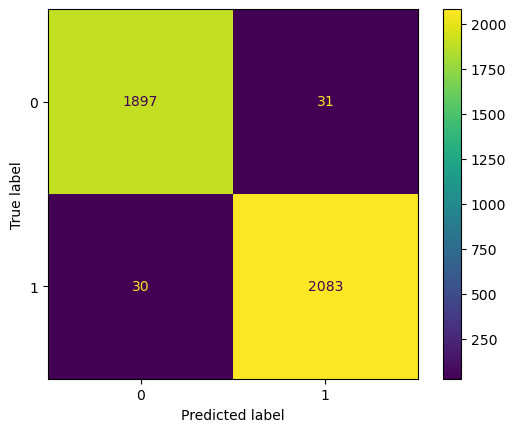

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_combined, predict)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [47]:
from sklearn.manifold import TSNE
news_to_plot_tsne = TSNE(random_state=0).fit_transform(X_test_combined)

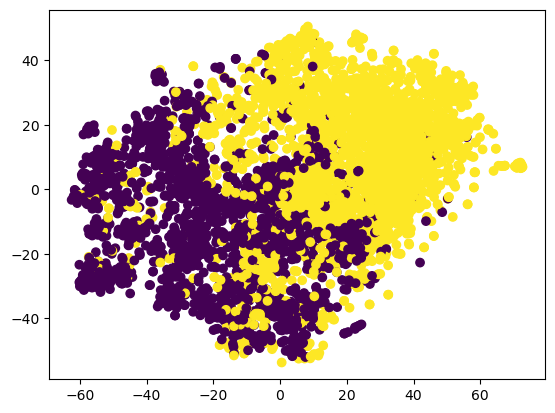

In [48]:
# истинное распределение объектов тестовой выборки по классам
plt.scatter(x=news_to_plot_tsne[:, 0],
            y=news_to_plot_tsne[:, 1],
            c=y_test_combined)
plt.show()

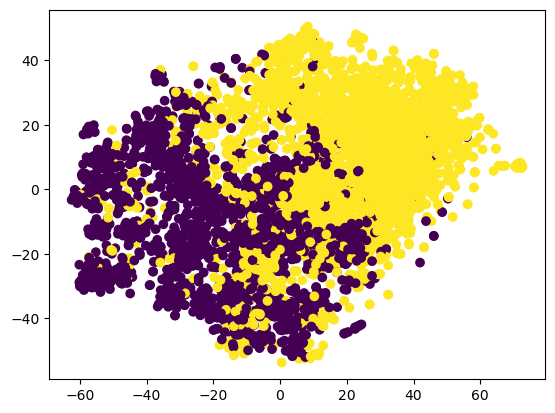

In [49]:
# предсказанное распределение объектов тестовой выборки по классам
plt.scatter(x=news_to_plot_tsne[:, 0],
            y=news_to_plot_tsne[:, 1],
            c=predict)
plt.show()

Видим, что действительно большая часть объектов классов распознаётся верно, а ошибки случаются в основном в точках, удалённых от основного скопления точек класса (это видно, например, по набору фиолетовых точек в нижней части рисунка).

### an attempt to analyse the errors qualitatively

Мы видим в матрице выше, что количество ложных ответов для обоих классов у нас достаточно низкое (по 30 из 2х тысяч). Становится интересно, чем эти тексты качественно отличаются от остальных представителей своих классов.

In [50]:
# 1. Исследуем фейки, определённые как реальные (False negatives)
news_pred_FN = news_test_predictions_df[
    (news_test_predictions_df['target'] == 1) &
    (news_test_predictions_df['predict'] == 0)
]
news_pred_FN

,title+text,target,predict
6822,BREAKING: OBAMA’S DOJ TO FAST TRACK $29 MILLIO...,1,0
9559,YOU’RE FIRED! WHY THE WHITE HOUSE Just Fired A...,1,0
7547,BUMBLING BILL CLINTON Manages To Insult Poland...,1,0
12069,JAMES COMEY’S Bombshell Pre-Testimony Statemen...,1,0
10192,REPORT: PRESIDENT TRUMP Is “Odds-On Favorite T...,1,0
9195,BREAKING: NORTH KOREA Detains American Student...,1,0
11924,JUST IN: Senior GOP Rep Announces His Retireme...,1,0
10108,USDA MIGHT WANT TO RETHINK REMOVING COUNTRY OF...,1,0
9960,EXPERT CLAIMS N. KOREA’S SECOND MISSILE Test D...,1,0
12601,REPUBLICAN SENATOR Sends Letter to FBI Directo...,1,0


In [99]:
# выбираем случайный текст из этих
news_pred_FN.sample()['title+text'].item()

'YOU’RE FIRED! WHY THE WHITE HOUSE Just Fired A Senior National Security Aide. National Security Council aide Craig Deare was dismissed on Friday after it was learned that he harshly criticized the President and his top aides.Deare s criticisms took place at an off-the-record roundtable and included attacking the President himself, chief strategist Stephen Bannon and the President s daughter Ivanka and son-in-law, Jared Kushner, both of whom serve as advisers.  He also claimed that the President had an embarrassing phone call with Mexico s president, Enrique Pena Nieto.Deare served as the NSC s senior director for Western Hemisphere Affairs and was previously the dean of administration at National Defense University.(Source: Free Beacon)'

In [105]:
# также выбираем случайный текст из истинных фейков 
# и сравниваем случайные тексты 
news_test_predictions_df[
    (news_test_predictions_df['target'] == 1) &
    (news_test_predictions_df['predict'] == 1)
].sample()['title+text'].item()

' Trump Gets His A** Handed To Him For Whining That Slain Soldier’s Dad ‘Viciously’ Attacked Him. Donald Trump woke up on Sunday morning and decided to play the victim and Twitter was NOT having any of it.On Saturday, the Republican nominee responded to the speech delivered by Khizr Khan, the father of an American soldier who sacrificed his life to save the lives of the soldiers under his command.Khan told the DNC Convention that Trump has never sacrificed anything for this country and doesn t know what sacrifice is, and Trump proved him right.During an interview with ABC, Trump claimed that he has sacrificed a lot by listing things that he has done like building crap with his name on it. But sacrifice requires giving up something for the greater good, and that does not include building high-priced resorts only the wealthy can enjoy in order to enrich yourself.Almost instantly, a new hashtag was born as #TrumpSacrifices trended on Twitter.On Sunday morning, Trump whined that it is unfa

После сравнения нескольких пар текстов я пришёл к выводу, что модель, по-видимому, скорее ошибается в случаях, когда в тексте представлено меньше заглавных букв, знаков препинания, какого-либо текстового мусора и также, возможно, именованных сущностей. В целом все FN выглядят действительно похожими на реальные новости, хотя и среди правильно классифицированных фейков обнаруживаются "адекватно" выглядящие тексты.

In [100]:
# 1. Исследуем реальные новости, определённые как фейки (False positives)
news_pred_FP = news_test_predictions_df[
    (news_test_predictions_df['target'] == 0) &
    (news_test_predictions_df['predict'] == 1)
]
news_pred_FP

,title+text,target,predict
2848,Factbox: Canada's immigration system and targe...,0,1
4491,Trump attends 'Villains and Heroes' costume pa...,0,1
275,Factbox: Legal issues in Supreme Court immigra...,0,1
4297,"Not an endorsement, but close; Obama comments ...",0,1
2708,Catalan police say Sagrada Familia bomb scare ...,0,1
750,A Picture and its Story: Reaching out to rescu...,0,1
3943,Trump's Russian imbroglio prompts Republican r...,0,1
876,"Senators push Trump to release White House, Ma...",0,1
269,Yemeni-Americans shut hundreds of shops in NY ...,0,1
3175,"Democrat Sanders, 'big fan of pope,' to attend...",0,1


In [117]:
# выбираем случайный текст из этих
news_pred_FP.sample()['title+text'].item()

'N.J. Governor Chris Christie accosts heckler in Milwaukee. NEW YORK (Reuters) - New Jersey Governor Chris Christie confronted a baseball fan who heckled him during a Sunday night game in Milwaukee, according to a video posted by local media, making the unpopular governor the target of another round of online jokes. The second-term Republican can be seen clutching a bowl of nachos and leaning over a man identified as Brad Joseph, telling him “you’re a big shot,” before walking away down a flight of stairs, according to a video of the incident posted online by Milwaukee’s WISN television. Joseph told the station he yelled Christie’s name when the governor was going up the stairs and called him a “hypocrite” during the game between the Milwaukee Brewers and Chicago Cubs. “(He) was yelling at me. First he told me, ‘Why don’t you have another beer?’ which I thought was a decent come back, and I thought that was kind of funny,” the station quoted Joseph as saying. “Then he started calling m

In [108]:
# также выбираем случайный текст из истинных реальных 
# и сравниваем случайные тексты 
news_test_predictions_df[
    (news_test_predictions_df['target'] == 0) &
    (news_test_predictions_df['predict'] == 0)
].sample()['title+text'].item()

'Flamboyant Hong Kong businessman David Tang dies aged 63. HONG KONG (Reuters) - Hong Kong businessman and socialite David Tang, known for founding the eponymous Shanghai Tang fashion brand, has died at the age of 63. Tang, who split his time between the Asian financial hub of Hong Kong and London, was well known for his satirical sense of humor as a weekly columnist in the Financial Times weekend edition. Lionel Barber, editor of the Financial Times, tweeted:  RIP Sir David Tang, businessman, philanthropist, networker supreme. He will be sorely missed as a friend and FT columnist.   Media reported he had battled liver cancer for some time.  Tang, the father of two children and husband of British-born Lucy Tang, moved to England at the age of 13 where he said he began boarding school without speaking a word of English. He set up his high-end tailor in 1994 and turned it into a global brand before Richemont took a controlling stake in 1998. Hong Kong-born Tang aimed to fuse east and wes

Мисклассифицированные реальные новости в целом похожи на реальные, поэтому предположить их сходство с фейками было сложнее. В части случаев FP-тексты оказывались очень длинными, что свойственно для фейков. Также, я полагаю, классификатор относит к фейкам тексты с большим количеством знаков препинания (например, если в тексте встречается много цитат, оформленных кавычками). 

Стоит также отметить, что на оба типа ошибок классификатора также, весьма вероятно, повлияли какие-то тематико-смысловые компоненты, проинтерпретировать которые вручную – достаточно сложная задача.

# 7. Topic modeling

In [11]:
news_df

,title+text,subject,date,target
0,Obama commends Northern Ireland leaders on pea...,politicsNews,"March 17, 2016",0
1,South Korea president says acquiring nukes wou...,politicsNews,"January 13, 2016",0
2,Catalan leader opens door to secession from Sp...,worldnews,"October 1, 2017",0
3,Japan ruling coalition seen winning around two...,worldnews,"October 18, 2017",0
4,British Columbia hires investigator to probe m...,worldnews,"September 29, 2017",0
...,...,...,...,...
13464,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,left-news,"Jul 15, 2015",1
13465,GREAT SPEECH! PRESIDENT TRUMP Doubles Down On ...,politics,"Jan 25, 2017",1
13466,DEFIANT NATIONAL PARK SERVICE STAFF GOES ROGUE...,Government News,"Jan 26, 2017",1
13467,Donald Trump Throws MASSIVE Hissy Fit Over Hi...,News,"July 29, 2016",1


Интересно посмотреть, что часто обсуждается в политических медиа данной выборки, отдельно в двух подвыборках, посмотреть, есть ли отличия фейков от реальных новостей по топикам.

Будем проводить тематический анализ с помощью gensim.

In [12]:
import re
from gensim.corpora import Dictionary 
from gensim.models import LdaModel, LsiModel, CoherenceModel

In [13]:
def evaluate_topic_modeling(model, corpus, texts, dictionary, is_lda=False):
    
    if is_lda:
        print(f'Perplexity: {model.log_perplexity(corpus)}')
        
    coherence_model_cv = CoherenceModel(
        model=model, 
        texts=texts, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    print(f'Coherence (C_V): {coherence_model_cv.get_coherence()}')
    
    coherence_model_umass = CoherenceModel(
        model=model, 
        texts=texts, 
        dictionary=dictionary, 
        coherence='u_mass'
    )
    print(f'Coherence (uMass): {coherence_model_umass.get_coherence()}')

## 7.1 Topic modeling on a whole corpus

In [14]:
# создаём словарь и корпус в формате генсима
news_dict = Dictionary(preprocessed_news)
news_corpus = [news_dict.doc2bow(text) for text in preprocessed_news]

In [15]:
news_corpus[807] # index, count

[(4, 1),
 (11, 2),
 (12, 2),
 (15, 5),
 (19, 2),
 (20, 1),
 (24, 1),
 (26, 2),
 (29, 5),
 (31, 4),
 (33, 2),
 (34, 14),
 (39, 4),
 (40, 1),
 (43, 1),
 (44, 4),
 (45, 2),
 (72, 5),
 (79, 8),
 (90, 2),
 (122, 1),
 (124, 1),
 (125, 1),
 (131, 2),
 (136, 1),
 (138, 2),
 (151, 1),
 (155, 1),
 (156, 1),
 (157, 1),
 (162, 1),
 (166, 1),
 (173, 2),
 (183, 2),
 (184, 1),
 (185, 1),
 (190, 1),
 (206, 1),
 (211, 2),
 (216, 3),
 (218, 1),
 (224, 1),
 (227, 1),
 (233, 1),
 (234, 3),
 (241, 7),
 (248, 1),
 (249, 1),
 (257, 1),
 (276, 1),
 (283, 4),
 (290, 1),
 (298, 5),
 (303, 1),
 (315, 1),
 (323, 1),
 (335, 1),
 (343, 1),
 (345, 1),
 (352, 3),
 (359, 1),
 (361, 1),
 (373, 3),
 (377, 2),
 (392, 1),
 (396, 1),
 (399, 1),
 (401, 2),
 (413, 3),
 (415, 1),
 (421, 1),
 (426, 1),
 (435, 2),
 (437, 1),
 (442, 1),
 (444, 2),
 (449, 1),
 (464, 3),
 (474, 1),
 (481, 2),
 (508, 2),
 (512, 3),
 (519, 2),
 (532, 1),
 (541, 22),
 (550, 1),
 (554, 1),
 (563, 1),
 (570, 1),
 (581, 1),
 (602, 1),
 (603, 3),
 (604, 

In [34]:
# обучаем LDA и LSA модели на 3 топика – дальше я буду подбирать это число в зависимости от качества моделей
lda_whole_corpus = LdaModel(corpus=news_corpus, num_topics=3, id2word=news_dict)
lsa_whole_corpus = LsiModel(corpus=news_corpus, num_topics=3, id2word=news_dict)

In [41]:
# посмотрим на результат работы LDA
lda_whole_corpus.show_topics()

[(0,
  '0.008*"said" + 0.005*"state" + 0.005*"year" + 0.005*"government" + 0.004*"group" + 0.004*"country" + 0.004*"people" + 0.003*"would" + 0.003*"muslim" + 0.003*"refugee"'),
 (1,
  '0.010*"trump" + 0.009*"said" + 0.005*"news" + 0.005*"president" + 0.005*"medium" + 0.004*"russia" + 0.004*"state" + 0.004*"time" + 0.004*"one" + 0.003*"year"'),
 (2,
  '0.019*"trump" + 0.007*"said" + 0.006*"president" + 0.005*"people" + 0.005*"clinton" + 0.005*"would" + 0.005*"state" + 0.005*"republican" + 0.005*"one" + 0.005*"obama"')]

In [42]:
# посмотрим на результат работы LSA
lsa_whole_corpus.show_topics()

[(0,
  '0.489*"trump" + 0.345*"said" + 0.192*"state" + 0.171*"president" + 0.163*"would" + 0.125*"republican" + 0.120*"clinton" + 0.115*"one" + 0.112*"year" + 0.104*"people"'),
 (1,
  '-0.768*"trump" + 0.215*"said" + 0.206*"state" + 0.141*"government" + 0.135*"group" + -0.111*"donald" + 0.111*"year" + 0.084*"organization" + 0.069*"right" + 0.065*"united"'),
 (2,
  '0.591*"said" + -0.265*"clinton" + -0.179*"medium" + -0.157*"group" + -0.151*"american" + -0.145*"organization" + -0.130*"hillary" + -0.127*"america" + 0.123*"reuters" + 0.120*"north"')]

In [47]:
# выделенные топики, на первый взгляд, мало чем различаются в обеих моделях
# давайте оценим получившиеся модели

# LDA - 3 topics:
evaluate_topic_modeling(lda_whole_corpus,
                       news_corpus,
                       preprocessed_news,
                       news_dict,
                       is_lda=True)

Perplexity: -8.434545774869802
Coherence (C_V): 0.3121780203975386
Coherence (uMass): -1.2204742911916402


In [44]:
# LSA - 3 topics:
evaluate_topic_modeling(lsa_whole_corpus,
                       news_corpus,
                       preprocessed_news,
                       news_dict)

Coherence (C_V): 0.38716039174584377
Coherence (uMass): -1.1685178212054372


In [49]:
# попробуем подобрать оптимальное количество топиков для обеих моделей
num_topics = [1, 3, 5, 9, 10, 15]

In [51]:
# для LDA:
for num in num_topics:
    
    print(f'LDA, num_topics: {num}')
    lda_whole_corpus = LdaModel(corpus=news_corpus, num_topics=num, id2word=news_dict)
    evaluate_topic_modeling(lda_whole_corpus,
                       news_corpus,
                       preprocessed_news,
                       news_dict,
                       is_lda=True)
    print()

LDA, num_topics: 1
Perplexity: -8.520245273505124
Coherence (C_V): 0.3240401344136367
Coherence (uMass): -0.9547610441887885

LDA, num_topics: 3
Perplexity: -8.451125634581537
Coherence (C_V): 0.29922617816048774
Coherence (uMass): -1.1742204058813657

LDA, num_topics: 5
Perplexity: -8.384261656828913
Coherence (C_V): 0.3949363149972855
Coherence (uMass): -1.2054066638072742

LDA, num_topics: 9
Perplexity: -8.63297648703883
Coherence (C_V): 0.40819949601733774
Coherence (uMass): -1.291636989274643

LDA, num_topics: 10
Perplexity: -8.721748000069994
Coherence (C_V): 0.3957521911662372
Coherence (uMass): -1.448656622303864

LDA, num_topics: 15
Perplexity: -9.059342947909885
Coherence (C_V): 0.41910087264894436
Coherence (uMass): -1.610548077784661



In [53]:
# для LSA:
for num in num_topics:
    
    print(f'LSA, num_topics: {num}')
    lsa_whole_corpus = LsiModel(corpus=news_corpus, num_topics=num, id2word=news_dict)
    evaluate_topic_modeling(lsa_whole_corpus,
                       news_corpus,
                       preprocessed_news,
                       news_dict)
    print()

LSA, num_topics: 1
Coherence (C_V): 0.34178268710938303
Coherence (uMass): -0.932233197080418

LSA, num_topics: 3
Coherence (C_V): 0.38716039174584377
Coherence (uMass): -1.1718751781443795

LSA, num_topics: 5
Coherence (C_V): 0.5047367699450354
Coherence (uMass): -4.727689592972039

LSA, num_topics: 9
Coherence (C_V): 0.3855972151066002
Coherence (uMass): -1.4114934674322

LSA, num_topics: 10
Coherence (C_V): 0.4260704666555185
Coherence (uMass): -1.41887111678693

LSA, num_topics: 15
Coherence (C_V): 0.39682447683284044
Coherence (uMass): -1.6612945178692307



In [18]:
# кажется, что увеличение числа топиков в целом не помогает,
# поэтому давайте поработаем с другими параметрами LDA c 9-ю топиками

alphas = [0.01, 0.07, 0.1, 0.4, 0.7, 1]
betas = [0.01, 0.07, 0.1, 0.4, 0.7, 1]

for alpha in alphas:
    for beta in betas:
    
        print(f'alpha: {alpha}, beta: {beta}')
        lda_whole_corpus = LdaModel(corpus=news_corpus, 
                                           num_topics=9, 
                                           id2word=news_dict,
                                           alpha=alpha,
                                           eta=beta)
        
        evaluate_topic_modeling(lda_whole_corpus,
                           news_corpus,
                           preprocessed_news,
                           news_dict,
                           is_lda=True)
        print()

alpha: 0.01, beta: 0.01
Perplexity: -13.404071099896314
Coherence (C_V): 0.37079024782860903
Coherence (uMass): -1.4696277282578527

alpha: 0.01, beta: 0.07
Perplexity: -9.059942185669755
Coherence (C_V): 0.40203075156146983
Coherence (uMass): -1.4340565643333998

alpha: 0.01, beta: 0.1
Perplexity: -8.735300044923047
Coherence (C_V): 0.4009615464225177
Coherence (uMass): -1.460114724630358

alpha: 0.01, beta: 0.4
Perplexity: -8.4274995110973
Coherence (C_V): 0.3878776493078513
Coherence (uMass): -1.6174290613010338

alpha: 0.01, beta: 0.7
Perplexity: -8.45055792457248
Coherence (C_V): 0.40426790713358707
Coherence (uMass): -1.9437913458436507

alpha: 0.01, beta: 1
Perplexity: -8.479759052561443
Coherence (C_V): 0.3962861324857609
Coherence (uMass): -2.424381045970291

alpha: 0.07, beta: 0.01
Perplexity: -13.345638499019223
Coherence (C_V): 0.3925964083094002
Coherence (uMass): -1.4158024736458752

alpha: 0.07, beta: 0.07
Perplexity: -9.057046861496412
Coherence (C_V): 0.340643666554273

Делаем вывод, что изменение параметров модели слабо влияет на метрики качества – значит, специфика наших данных такова, что в них сложно однозначно выделить топики, что подтверждается качественными результатами: ключевые слова выделенных ранее трёх топиков тематически не отличаются друг от друга и касаются преимущественно американской политики.

## 7.2 Topic modeling as a way to tell fakes and real news apart

Теперь попробуем смоделировать тематическое наполнение каждого подкорпуса отдельно. Для этого буду использовать LSA-модель с 5-ю топиками, так как она показала наилучший результат по метрике coherence C_V на кросс-валидации.

### Real news

In [33]:
news_df_true = pd.DataFrame()
news_df_true['title+text'] = df_true['title'] + '. ' + df_true['text']
true_preprocessed = preprocess_texts(news_df_true['title+text'])

In [22]:
news_true_dict = Dictionary(true_preprocessed)
news_true_corpus = [news_true_dict.doc2bow(text) for text in true_preprocessed]

In [23]:
lsa_true = LsiModel(corpus=news_true_corpus, num_topics=5, id2word=news_true_dict)

In [24]:
evaluate_topic_modeling(lsa_true,
                   news_true_corpus,
                   true_preprocessed,
                   news_true_dict)

Coherence (C_V): 0.34616870738234906
Coherence (uMass): -1.46576862295171


In [26]:
lsa_true.show_topics()

[(0,
  '0.518*"said" + 0.408*"trump" + 0.211*"state" + 0.184*"would" + 0.155*"president" + 0.152*"republican" + 0.119*"reuters" + 0.109*"year" + 0.097*"house" + 0.094*"government"'),
 (1,
  '-0.671*"trump" + 0.295*"said" + -0.256*"republican" + 0.148*"government" + 0.146*"state" + 0.121*"north" + -0.120*"clinton" + -0.105*"house" + 0.105*"korea" + 0.098*"year"'),
 (2,
  '-0.364*"trump" + -0.338*"north" + -0.324*"korea" + 0.273*"republican" + 0.249*"tax" + -0.219*"china" + 0.162*"bill" + -0.152*"united" + -0.141*"nuclear" + 0.140*"senate"'),
 (3,
  '-0.383*"tax" + -0.364*"north" + -0.338*"korea" + -0.247*"republican" + -0.199*"bill" + -0.193*"would" + -0.159*"china" + -0.158*"senate" + -0.154*"house" + 0.146*"said"'),
 (4,
  '-0.366*"party" + -0.357*"clinton" + 0.261*"tax" + -0.235*"election" + -0.212*"north" + -0.187*"republican" + -0.179*"korea" + 0.161*"trump" + -0.133*"candidate" + -0.132*"voter"')]

Мы можем также попробовать рассматривать "фейковость" и "реальность" новости как тему – то есть смоделировать по одному топику на оба подкорпуса и сравнить, будут ли различия в выделенных ключевых словах.

In [27]:
lsa_true_one_topic = LsiModel(corpus=news_true_corpus, num_topics=1, id2word=news_true_dict)

In [32]:
lsa_true_one_topic.show_topics(num_words=15)
# как видим, выделенный один топик похож на 5 выделенных ранее

[(0,
  '0.518*"said" + 0.408*"trump" + 0.211*"state" + 0.184*"would" + 0.155*"president" + 0.152*"republican" + 0.119*"reuters" + 0.109*"year" + 0.097*"house" + 0.094*"government" + 0.093*"new" + 0.091*"united" + 0.086*"also" + 0.085*"official" + 0.082*"election"')]

### Fake news

In [42]:
news_df_false = pd.DataFrame()
news_df_false['title+text'] = df_fake['title'] + '. ' + df_fake['text']
false_preprocessed = preprocess_texts(news_df_false['title+text'])

In [43]:
news_false_dict = Dictionary(false_preprocessed)
news_false_corpus = [news_false_dict.doc2bow(text) for text in false_preprocessed]

In [44]:
lsa_false = LsiModel(corpus=news_false_corpus, num_topics=5, id2word=news_false_dict)

In [45]:
evaluate_topic_modeling(lsa_false,
                   news_false_corpus,
                   false_preprocessed,
                   news_false_dict)

Coherence (C_V): 0.37411416604584014
Coherence (uMass): -1.446068079756728


In [46]:
lsa_false.show_topics()

[(0,
  '0.504*"trump" + 0.167*"president" + 0.157*"state" + 0.153*"clinton" + 0.152*"said" + 0.145*"one" + 0.129*"would" + 0.126*"people" + 0.123*"american" + 0.117*"medium"'),
 (1,
  '-0.712*"trump" + 0.209*"group" + 0.195*"state" + 0.165*"organization" + -0.125*"donald" + 0.125*"american" + 0.118*"government" + 0.092*"america" + 0.089*"medium" + 0.081*"clinton"'),
 (2,
  '0.318*"group" + -0.306*"clinton" + 0.276*"trump" + 0.268*"organization" + 0.176*"american" + -0.144*"hillary" + 0.138*"america" + -0.131*"said" + 0.122*"state" + 0.120*"support"'),
 (3,
  '-0.660*"clinton" + -0.290*"hillary" + 0.142*"people" + 0.136*"police" + -0.134*"email" + -0.126*"campaign" + 0.122*"said" + 0.108*"shooting" + 0.104*"year" + -0.104*"election"'),
 (4,
  '-0.300*"medium" + -0.278*"cia" + 0.232*"obama" + 0.198*"president" + -0.187*"trump" + 0.180*"said" + -0.173*"news" + 0.163*"people" + 0.160*"republican" + 0.128*"state"')]

In [47]:
lsa_false_one_topic = LsiModel(corpus=news_false_corpus, num_topics=1, id2word=news_false_dict)

In [48]:
lsa_false_one_topic.show_topics(num_words=15)

[(0,
  '0.504*"trump" + 0.167*"president" + 0.157*"state" + 0.153*"clinton" + 0.152*"said" + 0.145*"one" + 0.129*"would" + 0.126*"people" + 0.123*"american" + 0.117*"medium" + 0.108*"time" + 0.107*"year" + 0.104*"also" + 0.101*"obama" + 0.101*"like"')]

В итоге, кажется, что набор топиков и ключевых слов для одного выделенного топика слабо отличается в реальных и фейковых новостях, поэтому, получается, что различить эти два класса с помощью тематического моделирования невозможно.